In [91]:
import typing
import itertools

import pandas
import seaborn
from matplotlib import pyplot

import cltrier_lib

import twon_agents

In [92]:
SEED: int = 1
DATA_PATH: str = "../../../data"

METRICS: typing.List[str] = [
    "public_metrics.impression_count",
    "public_metrics.like_count",
    "public_metrics.retweet_count",
    "public_metrics.reply_count",
]

In [93]:
posts: pandas.DataFrame = twon_agents.data.filter_tweets(
    pandas.read_csv(
        f"{DATA_PATH}/raw/twitter.german/GermanyMdBTweets_2023.csv", index_col=0
    )
    .pipe(lambda _df: _df.assign(created_at=pandas.to_datetime(_df["created_at"])))
    .merge(
        right=pandas.read_json(f"{DATA_PATH}/raw/twitter.german/mdb_meta.json"),
        left_on="username",
        right_on="twitter_username",
    )
)
posts

,id,author_id,conversation_id,text,public_metrics.retweet_count,public_metrics.reply_count,public_metrics.like_count,public_metrics.quote_count,public_metrics.impression_count,public_metrics.bookmark_count,created_at,username,twitter_username,first_name,last_name,party,role
3,1645675247595581440,1040160799208161280,1645675245141884928,Wenn wir Männern wie Xi &amp; Putin signalisie...,48,30,356,6,17359,NaN,2023-04-11 06:28:48+00:00,n_roettgen,n_roettgen,Norbert,Röttgen,CDU/CSU,MdB
4,1621500636197003265,1040160799208161280,1621500633403604992,Als Opposition ist es unsere demokratische Auf...,71,18,402,1,7569,NaN,2023-02-03 13:27:32+00:00,n_roettgen,n_roettgen,Norbert,Röttgen,CDU/CSU,MdB
7,1613459277477302273,1040160799208161280,1613459266932703232,"5/6 Der Idealfall wäre, wenn Deutschland jetzt...",68,15,649,2,10753,NaN,2023-01-12 08:54:03+00:00,n_roettgen,n_roettgen,Norbert,Röttgen,CDU/CSU,MdB
8,1613459271672266752,1040160799208161280,1613459266932703232,"3/6 Immer mehr Staaten begreifen, dass der Kri...",47,8,522,0,8803,NaN,2023-01-12 08:54:01+00:00,n_roettgen,n_roettgen,Norbert,Röttgen,CDU/CSU,MdB
9,1645389288551358465,1040160799208161280,1645389286978600964,"Selbiger 🇫🇷 Präsident, der vor einiger Zeit di...",61,24,792,4,25793,NaN,2023-04-10 11:32:30+00:00,n_roettgen,n_roettgen,Norbert,Röttgen,CDU/CSU,MdB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37208,1610326064605310976,97530140,1610326064605310976,Wieviele Silvesternächte mit Straftaten &amp; ...,31,20,196,1,3127,NaN,2023-01-03 17:23:46+00:00,MalteKaufmann,MalteKaufmann,Malte,Kaufmann,AfD,MdB
37209,1610129842099585024,97530140,1610129842099585024,Klar ist: Wer hier als Ausländer unseren Staat...,145,45,1073,6,16841,NaN,2023-01-03 04:24:03+00:00,MalteKaufmann,MalteKaufmann,Malte,Kaufmann,AfD,MdB
37210,1609821802993442816,97530140,1609821802993442816,Die Lösung für die Angriffe auf Rettungskräfte...,56,32,398,4,9542,NaN,2023-01-02 08:00:01+00:00,MalteKaufmann,MalteKaufmann,Malte,Kaufmann,AfD,MdB
37258,1663108743758790657,97530140,1663108743758790657,#Freiheit statt Verbote und Bevormundung. Imme...,51,7,212,0,2087,0.0,2023-05-29 09:03:18+00:00,MalteKaufmann,MalteKaufmann,Malte,Kaufmann,AfD,MdB


<Axes: xlabel='week', ylabel='count'>

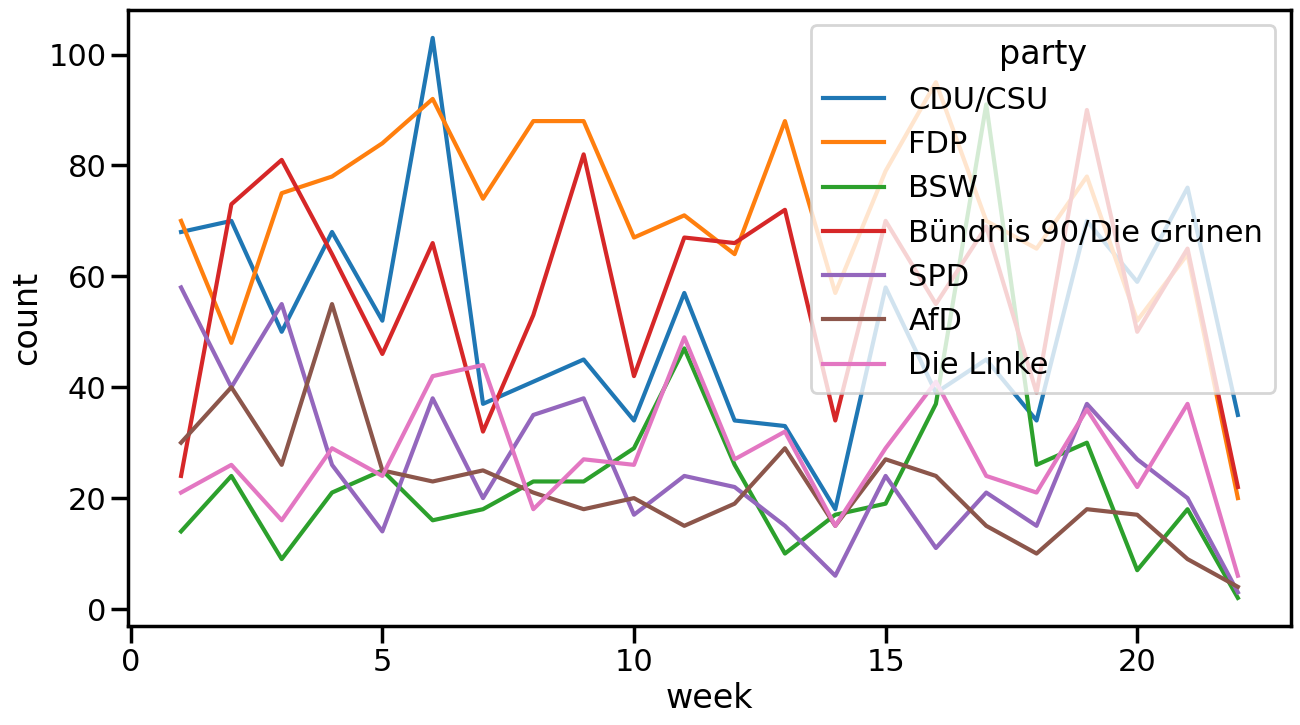

In [94]:
pyplot.figure(figsize=(15, 8))
seaborn.set_context("poster")

seaborn.lineplot(
    data=(
        posts.assign(week=posts["created_at"].dt.isocalendar().week)[["party", "week"]]
        .pipe(lambda _df: _df[_df["week"] != 52])
        .value_counts()
        .to_frame()
        .reset_index()
    ),
    x="week",
    y="count",
    hue="party",
)

In [95]:
# calculate the distribution of replies
post_reply_dist: pandas.Series = (
    posts["public_metrics.reply_count"]
    .value_counts()
    .describe(percentiles=[0.25, 0.5, 0.75, 0.8, 0.85, 0.9, 0.95])
)
post_reply_dist

count    797.000000
mean       7.764115
std       34.252016
min        1.000000
25%        1.000000
50%        2.000000
75%        4.000000
80%        5.000000
85%        7.000000
90%       12.000000
95%       20.200000
max      680.000000
Name: count, dtype: float64

In [96]:
# generate a subset containing only the 90% most commented tweets
posts = posts[posts["public_metrics.reply_count"] > post_reply_dist.loc["90%"]]
len(posts)

3432

In [97]:
# calculate the distribution of user activity (number of posts)
user_activity_dist: pandas.Series = (
    posts["username"]
    .value_counts()
    .describe(percentiles=[0.25, 0.4, 0.5, 0.6, 0.75, 0.8, 0.85, 0.9, 0.95])
)
user_activity_dist

count     61.000000
mean      56.262295
std       56.101367
min       16.000000
25%       24.000000
40%       33.000000
50%       38.000000
60%       47.000000
75%       62.000000
80%       63.000000
85%       89.000000
90%      108.000000
95%      161.000000
max      327.000000
Name: count, dtype: float64

In [98]:
selected_percentile: str = "75%"

sampled_posts: pandas.DataFrame = (
    posts[
        # select only the 80% most active users
        posts["username"].isin(
            list(
                (
                    posts["username"].value_counts()
                    > user_activity_dist.loc[selected_percentile]
                )
                .pipe(lambda _s: _s[_s])
                .index
            )
        )
    ]
    .groupby("username")
    # sample by number of least active 80%' user posts
    .sample(n=int(user_activity_dist.loc[selected_percentile]), random_state=SEED)
)

len(sampled_posts), len(sampled_posts["username"].unique())

(868, 14)

In [99]:
sampled_posts

,id,author_id,conversation_id,text,public_metrics.retweet_count,public_metrics.reply_count,public_metrics.like_count,public_metrics.quote_count,public_metrics.impression_count,public_metrics.bookmark_count,created_at,username,twitter_username,first_name,last_name,party,role
30977,1625772644120334336,805308596,1625772644120334336,Beim Bunkerbesuch in 🇫🇮 fängt unsere Außenmini...,315,391,3328,13,75171,NaN,2023-02-15 08:22:58+00:00,Beatrix_vStorch,Beatrix_vStorch,Beatrix,von Storch,AfD,MdB
30972,1624882807259467777,805308596,1624882807259467777,AfD-stabil mit Zugewinnen in einer Stadt im li...,108,230,1528,5,42833,NaN,2023-02-12 21:27:04+00:00,Beatrix_vStorch,Beatrix_vStorch,Beatrix,von Storch,AfD,MdB
30956,1649799899679014915,805308596,1649799899679014915,"Der heutige #EarthDay2023 unter dem Motto ""Woh...",124,154,969,3,21361,NaN,2023-04-22 15:38:42+00:00,Beatrix_vStorch,Beatrix_vStorch,Beatrix,von Storch,AfD,MdB
30856,1612788201877282817,805308596,1612788201877282817,Linksgrüner #Staatsfunk schürt #Klimapanik. Li...,551,627,3254,23,87306,NaN,2023-01-10 12:27:26+00:00,Beatrix_vStorch,Beatrix_vStorch,Beatrix,von Storch,AfD,MdB
30865,1647187822753861632,805308596,1647187822753861632,Das heutige Ende der #Kernkraft ist auch ein A...,116,178,756,4,15604,NaN,2023-04-15 10:39:14+00:00,Beatrix_vStorch,Beatrix_vStorch,Beatrix,von Storch,AfD,MdB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,1641705169422303232,1040160799208161280,1641705166930866177,"Auf den Bürger zu verweisen, der beim #Klimasc...",28,14,192,0,5002,NaN,2023-03-31 07:33:08+00:00,n_roettgen,n_roettgen,Norbert,Röttgen,CDU/CSU,MdB
194,1616759620143292417,1040160799208161280,1616759620143292417,Dass der Kanzler in #Ramstein nicht geliefert ...,1159,1070,5369,77,136574,NaN,2023-01-21 11:28:26+00:00,n_roettgen,n_roettgen,Norbert,Röttgen,CDU/CSU,MdB
414,1610607783254298624,1040160799208161280,1610607774643224577,Das Auswärtige Amt täuscht die Öffentlichkeit ...,994,96,2597,17,29047,NaN,2023-01-04 12:03:13+00:00,n_roettgen,n_roettgen,Norbert,Röttgen,CDU/CSU,MdB
412,1659447745755721734,1040160799208161280,1659447740458319872,"Wenn wir der #Ukraine nicht mit Waffen helfen,...",26,27,215,0,7267,0.0,2023-05-19 06:35:48+00:00,n_roettgen,n_roettgen,Norbert,Röttgen,CDU/CSU,MdB


In [100]:
(
    sampled_posts[["first_name", "last_name", "party"]]
    .drop_duplicates()
    .set_index("party")
    .sort_index()
)

,first_name,last_name
party,,
AfD,Beatrix,von Storch
AfD,Joana,Cotar
Bündnis 90/Die Grünen,Katrin,Göring-Eckardt
Bündnis 90/Die Grünen,Ricarda,Lang
CDU/CSU,Friedrich,Merz
CDU/CSU,Norbert,Röttgen
Die Linke,Niema,Movassat
FDP,Marco,Buschmann
FDP,Marcus,Faber


In [102]:
(
    sampled_posts.reset_index()[
        [
            "id",
            "author_id",
            "conversation_id",
            "first_name",
            "last_name",
            "username",
            "party",
            "created_at",
            "text",
        ]
    ].to_csv(f"{DATA_PATH}/interim/twitter.german.posts.csv")
)

In [103]:
user_metric = (
    sampled_posts[["username", *METRICS]]
    .groupby("username")
    .agg(
        [
            "min",
            "max",
            "mean",
            "std",
        ]
    )
    .sort_values(by=("public_metrics.like_count", "mean"), ascending=False)
    .round(3)
)
user_metric

public_metrics.impression_count                       \
                                            min      max        mean   
username                                                               
Beatrix_vStorch                           10810   191426   44476.065   
n_roettgen                                 5002   312003   36245.129   
NiemaMovassat                              3762   362822   51801.887   
JoanaCotar                                 4720    56942   19321.661   
_FriedrichMerz                             9904   548920  102995.113   
MiRo_SPD                                   3353   425432   53493.532   
Ricarda_Lang                               4383   650724   86599.758   
MarcoBuschmann                             6004  1185289   86336.484   
c_lindner                                 10790  1429938  140500.435   
maxmordhorst                               2517   527711   59972.871   
MarcusFaber                                1015    93540   15174.097   
GoeringEckardt                             1849   443371   52351.274   
Wissing                                    6364   452030   62737.387   
Ralf_Stegner                               2055   534757   34216.661   

                            public_metrics.like_count                  \
                        std                       min   max      mean   
username                                                                
Beatrix_vStorch   33868.518                       492  8311  2231.435   
n_roettgen        52018.575                       108  9831  1751.468   
NiemaMovassat     70857.910                        61  7295  1192.081   
JoanaCotar        14592.318                       143  4391  1173.258   
_FriedrichMerz   122727.140                        97  7209  1099.871   
MiRo_SPD          74843.317                        33  4798   808.984   
Ricarda_Lang     128800.216                        46  9195   650.403   
MarcoBuschmann   166306.002                        30  8035   561.242   
c_lindner        234439.207                        30  4388   561.048   
maxmordhorst     101209.636                        16  5773   440.339   
MarcusFaber       20018.050                        49  1606   374.161   
GoeringEckardt    99888.416                        18  6634   335.161   
Wissing           86694.031                        16  3326   303.871   
Ralf_Stegner      81082.959                        11  1660   190.952   

                          public_metrics.retweet_count                 \
                      std                          min   max     mean   
username                                                                
Beatrix_vStorch  1524.892                           54   946  307.161   
n_roettgen       2347.367                            8  5217  630.677   
NiemaMovassat    1698.436                            2  1172  152.210   
JoanaCotar        900.438                           10   563  149.806   
_FriedrichMerz   1279.063                           10   674  108.806   
MiRo_SPD          905.528                            4   448   78.629   
Ricarda_Lang     1276.974                            0  1495   61.113   
MarcoBuschmann   1200.473                            2   436   46.194   
c_lindner         822.430                            3   242   43.484   
maxmordhorst      806.032                            1   406   32.726   
MarcusFaber       303.818                            2   169   40.226   
GoeringEckardt    893.367                            0   956   40.129   
Wissing           489.660                            2   282   24.758   
Ralf_Stegner      350.444                            1   194   18.565   

                          public_metrics.reply_count                          
                      std                        min   max     mean      std  
username                                                                      
Beatrix_vStorch   207.805                         39   919  277.419  1

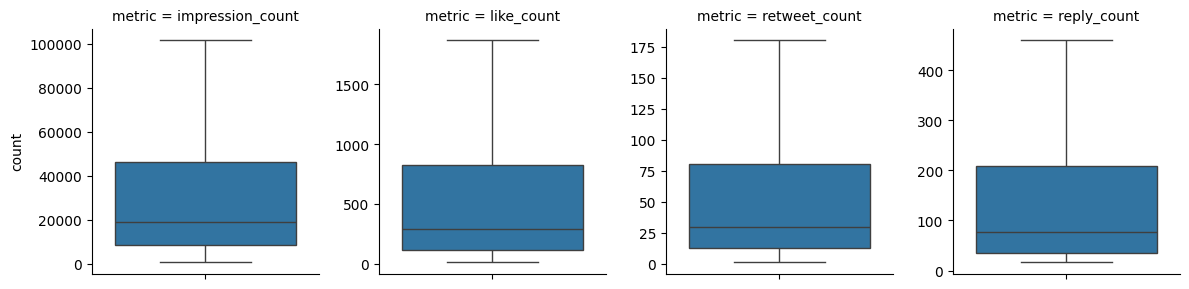

In [30]:
grid = seaborn.FacetGrid(
    data=(
        sampled_posts[METRICS]
        .melt(var_name="metric", value_name="count")
        .pipe(
            lambda _df: _df.assign(
                metric=_df["metric"].str.replace("public_metrics.", "")
            )
        )
    ),
    col="metric",
    sharey=False,
)
grid.map_dataframe(seaborn.boxplot, y="count", showfliers=False)

In [31]:
metrics_by_party = (
    sampled_posts.set_index("username")
    .merge(
        right=pandas.read_json(
            f"{DATA_PATH}/raw/twitter.german/mdb_meta.json"
        ).set_index("twitter_username"),
        left_index=True,
        right_index=True,
    )
    .pipe(lambda _df: _df[_df["role"] == "MdB"])[["party", *METRICS]]
    .groupby("party")
    .agg(
        [
            "min",
            "max",
            "mean",
            "std",
        ]
    )
    .sort_values(by=("public_metrics.like_count", "mean"), ascending=False)
)
metrics_by_party

public_metrics.impression_count                         \
                                                  min      max          mean   
party                                                                          
AfD                                              3127   262690  38271.940476   
BSW                                              7150   256451  51099.416667   
CDU/CSU                                          2555  1385611  56728.208333   
Die Linke                                        2052   408176  40817.416667   
Bündnis 90/Die Grünen                             602   403558  39243.161111   
FDP                                              2044   452030  53259.651515   
SPD                                               996   167152  26831.950000   

                                     public_metrics.like_count         \
                                 std                       min    max   
party                                                                   
AfD                     43308.890559                        77  12771   
BSW                     73779.411503                       364   4160   
CDU/CSU                152543.759506                        13  12022   
Die Linke               69787.727501                        23   1965   
Bündnis 90/Die Grünen   56054.910677                        17   5657   
FDP                     83620.493076                        16   3326   
SPD                     35685.893401                        12   2165   

                                                public_metrics.retweet_count  \
                              mean          std                          min   
party                                                                          
AfD                    2021.547619  2241.986267                            6   
BSW                    1268.166667  1379.515385                           59   
CDU/CSU                 768.366667  1552.332195                            1   
Die Linke               501.388889   529.594523                            3   
Bündnis 90/Die Grünen   486.600000   710.594956                            1   
FDP                     441.060606   591.399695                            3   
SPD                     336.316667   477.101009                            1   

                                                     \
                        max        mean         std   
party                                                 
AfD                    1697  295.500000  340.698591   
BSW                     823  240.583333  276.948127   
CDU/CSU                6424  168.925000  752.737304   
Die Linke               240   48.638889   53.670504   
Bündnis 90/Die Grünen   787   50.905556   84.353850   
FDP                     316   45.181818   59.861012   
SPD                     703   48.983333  103.546844   

                      public_metrics.reply_count                                
                                             min   max        mean         std  
party                                                                           
AfD                                           17  1195  209.702381  241.578932  
BSW                                           31  1304  260.583333  385.059018  
CDU/CSU                                       16  2236  191.241667  322.697584  
Die Linke                                     17   530  107.722222  134.332553  
Bündnis 90/Die Grünen                         16  2974  209.744444  345.743957  
FDP                                           16  3137  237.204545  391.678240  
SPD                                           18  1465  196.766667  319.633867

In [32]:
metrics_by_party.style.format(
    {key: "{:.2f}" for key in itertools.product(METRICS, ["mean", "std"])}
).background_gradient()

In [33]:
classified_data = pandas.json_normalize(
    [
        sample.model_dump()
        for sample in cltrier_lib.classify.Pipeline()(
            list(sampled_posts["text"]), threshold=0.0
        )
    ]
)
classified_data

,sample,results.topics.arts_&_culture,results.topics.business_&_entrepreneurs,results.topics.celebrity_&_pop_culture,results.topics.diaries_&_daily_life,results.topics.family,results.topics.fashion_&_style,results.topics.film_tv_&_video,results.topics.fitness_&_health,results.topics.food_&_dining,...,results.emotions.trust,results.sentiment.negative,results.sentiment.neutral,results.sentiment.positive,results.irony.non_irony,results.irony.irony,results.offensive.non-offensive,results.offensive.offensive,results.hate.NOT-HATE,results.hate.HATE
0,Verheerende Bilanz der Ampel: 783.000 Tatverdä...,0.049216,0.019987,0.010495,0.034500,0.001857,0.002134,0.026215,0.001907,0.001466,...,0.023664,0.188873,0.799625,0.470375,0.804436,0.250622,0.701602,0.306480,0.962485,0.041475
1,"Statt jegliche Verhandlungen abzulehnen, täte ...",0.026015,0.010681,0.017340,0.033952,0.003003,0.001364,0.021956,0.002919,0.002413,...,0.023060,0.344867,0.781938,0.276057,0.757068,0.334605,0.683155,0.332109,0.894197,0.107060
2,Die Wahrheit ist: Keine echte Fachkraft dieses...,0.138921,0.008744,0.009765,0.104401,0.005710,0.001283,0.018704,0.001544,0.003554,...,0.056527,0.182271,0.806196,0.464130,0.791387,0.259459,0.690443,0.316999,0.947043,0.057651
3,Dass ein Gesundheitssystem das bedingungslose ...,0.080515,0.006388,0.014652,0.132132,0.005177,0.001326,0.011450,0.001943,0.002333,...,0.015827,0.225521,0.782119,0.431825,0.802817,0.290089,0.670879,0.347833,0.954157,0.050746
4,"#Deutschland braucht einen Außenminister, der ...",0.016002,0.008558,0.011285,0.031861,0.002017,0.001197,0.011644,0.002017,0.001156,...,0.038786,0.175190,0.795425,0.495959,0.803558,0.280722,0.700591,0.311810,0.954269,0.050717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
931,"Jede Person, die gerade twittert, dass Deutsch...",0.147713,0.006904,0.031888,0.311543,0.004672,0.002479,0.033514,0.001842,0.001680,...,0.057648,0.253709,0.774138,0.403954,0.808336,0.294278,0.631089,0.377539,0.963490,0.040592
932,Wir müssen dringend mehr tun in der Klimapolit...,0.122707,0.006968,0.038760,0.117788,0.005441,0.001767,0.027902,0.002934,0.001168,...,0.047150,0.178382,0.800701,0.490706,0.241948,0.784331,0.681229,0.327864,0.959038,0.047593
933,Sinn der #Verkehrswende kann es übrigens nicht...,0.155517,0.040401,0.017224,0.231362,0.003396,0.005779,0.031422,0.001277,0.003284,...,0.036142,0.185968,0.815146,0.476455,0.402942,0.653197,0.696138,0.318583,0.963905,0.044544
934,Boris #Palmer ist kein Mitglied meiner Partei ...,0.008709,0.004479,0.068571,0.025677,0.001535,0.001235,0.019723,0.003518,0.000713,...,0.030183,0.298675,0.740355,0.352405,0.729509,0.327332,0.670343,0.334304,0.941489,0.065155


<Axes: xlabel='value', ylabel='variable'>

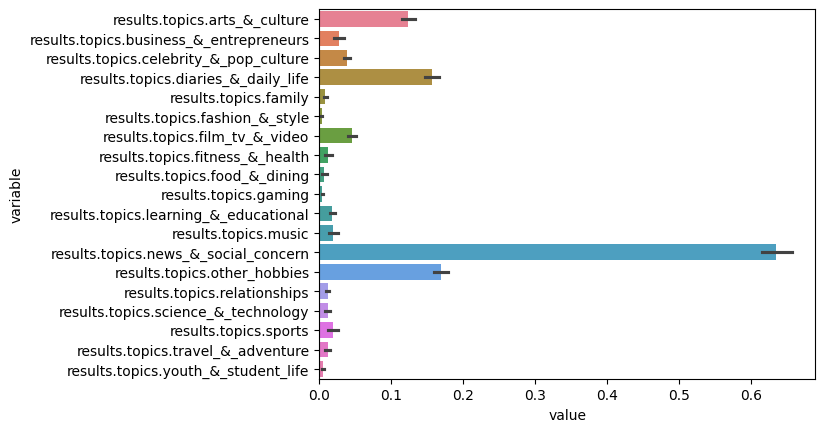

In [34]:
seaborn.barplot(
    classified_data.filter(like=".topics.").melt(),
    x="value",
    y="variable",
    hue="variable",
)

<Axes: xlabel='value', ylabel='variable'>

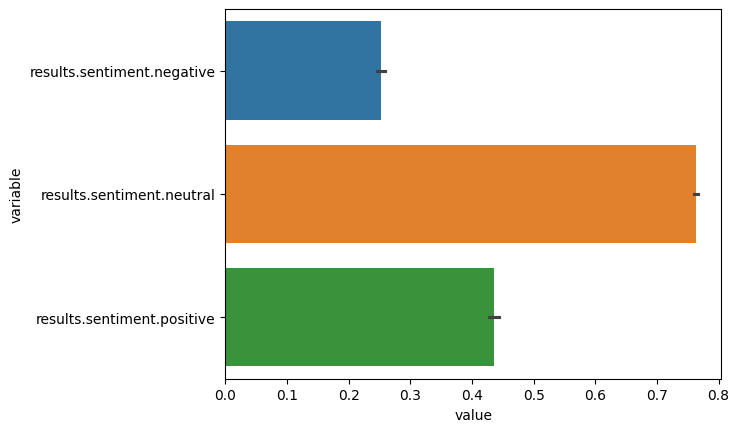

In [35]:
seaborn.barplot(
    classified_data.filter(like=".sentiment.").melt(),
    x="value",
    y="variable",
    hue="variable",
)

<Axes: xlabel='value', ylabel='variable'>

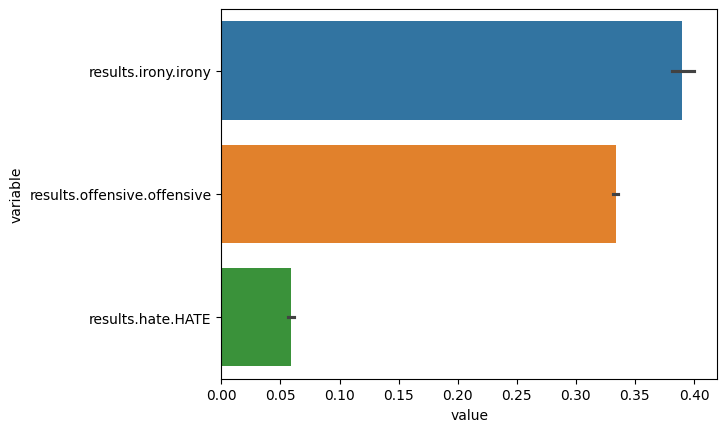

In [36]:
seaborn.barplot(
    classified_data.filter(regex="irony\.irony|offensive\.offensive|hate\.HATE").melt(),
    x="value",
    y="variable",
    hue="variable",
)